# Feature Selection for all recordings to select optimum set of features

In [1]:
import numpy as np
import mne
from scipy import signal
from scipy.interpolate import RectBivariateSpline
from mne.filter import resample, filter_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize, ListedColormap

import logging
LOGGING_TYPES = dict(DEBUG=logging.DEBUG, INFO=logging.INFO, WARNING=logging.WARNING,
                     ERROR=logging.ERROR, CRITICAL=logging.CRITICAL)
logger = logging.getLogger('yasa')

# %matplotlib qt


In [2]:
# load reference_df     
reference_df = pd.read_csv("reference_df.csv", index_col="name")


In [3]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import kruskal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# ANOVA F-value

In [4]:
def feature_selection_f_classif(x, y):
    """
    Compute the ANOVA F-value for the provided sample.
    Example
    -------
    >>> fvals = feature_selection_f_classif(df_feat, hypno_30s)
    """
    k_best = SelectKBest(f_classif, k="all")
    fit = k_best.fit(x, y)
    # print("Scores: ", fit.scores_)
    # ranking = fit.get_support()
    # print("Ranking: ", ranking)
    # features = fit.transform(x)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


fvals_df = None

for fname in reference_df.index.to_list():

    # to load hypno:
    hypno_loc = reference_df.loc[fname, "hypno"]
    hypno_30s = np.loadtxt(hypno_loc)[:, 0]

    # to load features:
    df_feat_loc = reference_df.loc[fname, "df_feat"]
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.iloc[hypno_30s != -1]  # do not process -1/artifact
    hypno_30s = hypno_30s[hypno_30s != -1]  # do not process -1/artifact

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the ANOVA F-value for the provided sample
    fvals = feature_selection_f_classif(df_feat, hypno_30s)

    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f'ANOVA F-value for features {fname}')
    # sns.barplot(y=fvals.index, x=fvals, palette="RdYlGn")
    # plt.xlabel("ANOVA F-value")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_fclassif figures/fs_fclassif {fname}.png", format="png")
    # plt.savefig(f"fs_fclassif figures/fs_fclassif {fname}.svg", format="svg")
    # plt.close(fig)

    fvals["name"] = fname

    if fvals_df is None:  # if not exist, then create it
        fvals_df = pd.DataFrame(columns=fvals.index)
        fvals_df = pd.concat([fvals_df, fvals.to_frame().T])
    else:  # fill it
        fvals_df = pd.concat([fvals_df, fvals.to_frame().T])

fvals_df = fvals_df.set_index("name")
fvals_rank_df = fvals_df.rank(1, ascending=False, method="first")


In [5]:
fvals_df.head()

,mean,mean_distance,kurt,tsallisEnt,ta_ab,skew,kurt_psd,hmob_psd,skew_psd,hcomp_psd,...,ta_b,ag,sb,bs,ab,bubbleEnt2,bubbleEnt1,higuchi,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.0928,6.149911,7.692397,11.067577,14.120312,14.196453,15.915379,17.275372,18.200308,18.566625,...,322.636758,349.377676,408.420443,425.036249,465.798516,477.2886,503.638771,549.004697,727.020899,733.173883
P18_N2 R,1.500872,10.749421,12.394198,6.636104,134.130197,14.671352,0.629736,2.685262,0.180387,1.173113,...,380.517748,179.256889,185.807955,274.501092,276.15998,326.350628,319.089471,321.482972,357.859509,376.608552
P17_N2 L,0.101974,13.74741,4.106133,1.912803,23.509277,24.574931,34.463018,28.87749,31.529567,47.311055,...,98.802522,48.973867,184.81137,88.172361,103.455912,143.761545,140.083655,156.364232,156.887225,158.272113
P15_N3 L,0.203199,1.480968,12.550943,4.6729,43.016497,20.763756,30.550745,27.175153,33.382739,25.066674,...,375.339801,310.956197,383.652952,185.725355,369.576229,138.154496,160.329126,88.843691,82.148455,92.989689
P15_N2 L,1.829339,2.444973,11.41833,12.688154,32.638936,15.668298,11.526563,9.559136,12.219586,9.148662,...,33.889055,53.687051,72.672184,35.712206,49.578912,54.414961,66.50891,83.255641,96.330132,102.109769


In [6]:
fvals_rank_df.head()

,mean,mean_distance,kurt,tsallisEnt,ta_ab,skew,kurt_psd,hmob_psd,skew_psd,hcomp_psd,...,ta_b,ag,sb,bs,ab,bubbleEnt2,bubbleEnt1,higuchi,petrosian,perm_entropy
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,75.0,74.0,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,72.0,64.0,63.0,66.0,19.0,60.0,74.0,71.0,75.0,73.0,...,1.0,14.0,13.0,10.0,9.0,5.0,7.0,6.0,3.0,2.0
P17_N2 L,75.0,59.0,73.0,74.0,45.0,41.0,27.0,34.0,31.0,22.0,...,9.0,20.0,1.0,11.0,8.0,6.0,7.0,5.0,4.0,3.0
P15_N3 L,75.0,74.0,71.0,73.0,40.0,63.0,51.0,56.0,49.0,59.0,...,2.0,6.0,1.0,9.0,3.0,12.0,10.0,17.0,21.0,16.0
P15_N2 L,75.0,74.0,64.0,59.0,34.0,53.0,63.0,68.0,60.0,69.0,...,33.0,12.0,6.0,28.0,17.0,11.0,7.0,3.0,2.0,1.0


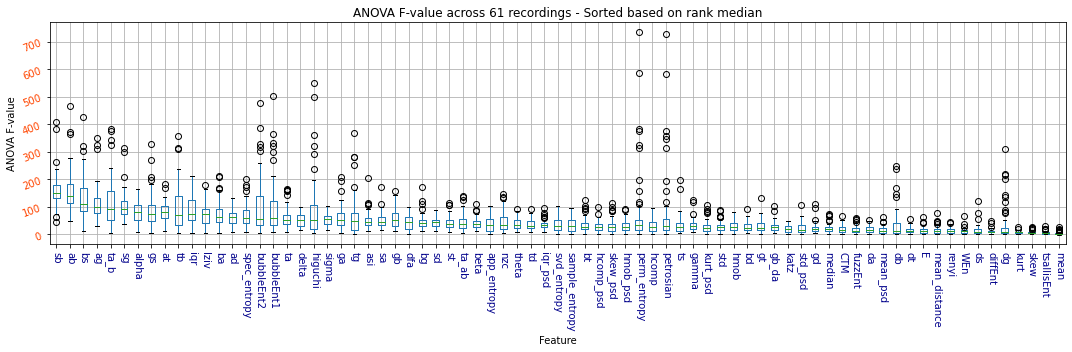

In [7]:
plt.figure(figsize=(15,5))
fvals_df = fvals_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
fvals_rank_df = fvals_rank_df.rename(columns={'central_tendency_measure':"CTM"})

fvals_df = fvals_df.astype(float)
fvals_df = fvals_df[fvals_rank_df.median().sort_values().index]
ax = fvals_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("ANOVA F-value")
plt.title(f"ANOVA F-value across {reference_df.shape[0]} recordings - Sorted based on rank median")
plt.tight_layout()
plt.savefig("fs_fclassif_ranking.png")
plt.savefig("fs_fclassif_ranking.svg")
plt.show()

## Plot signal with the best feature from ANOVA

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1691 samples (6.605 sec)



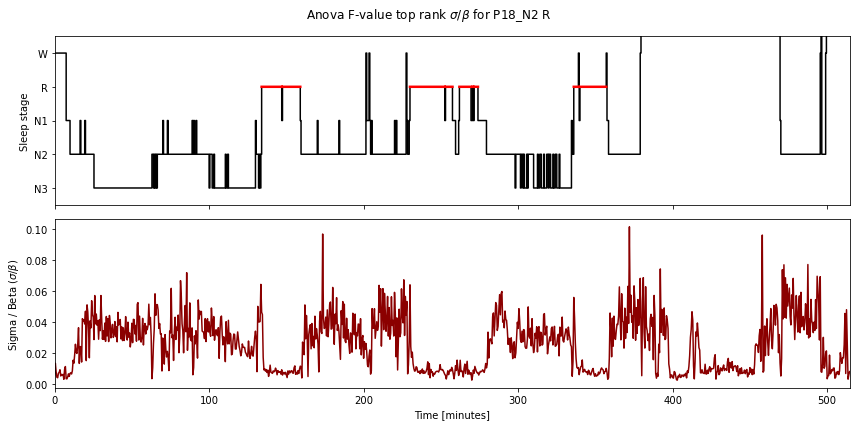

In [8]:
# Load the EDF file
fname = "P18_N2"  # define here
lr = "R"  # define here
location = f"/Users/amirhosseindaraie/Desktop/data/autoscoring-material/data/Zmax Donders/{fname}"
raw = mne.io.read_raw_edf(f"{location}/EEG {lr}.edf", preload=True, verbose=0)
raw.pick_types(eeg=True)
# fig = raw.plot(use_opengl=False)

# Apply a zero-phase bandpass filter between 0.5 ~ 45 Hz
raw.filter(0.5, 45)

# Extract the data and convert from V to uV
data = raw._data * 1e6
sf = raw.info["sfreq"]
chan = raw.ch_names

# Time vector in seconds
times = np.arange(data.size) / sf


def sliding_window(data, sf, window, step=None, axis=-1):
    """Calculate a sliding window of a 1D or 2D EEG signal.
    .. versionadded:: 0.1.7
    Parameters
    ----------
    data : numpy array
        The 1D or 2D EEG data.
    sf : float
        The sampling frequency of ``data``.
    window : int
        The sliding window length, in seconds.
    step : int
        The sliding window step length, in seconds.
        If None (default), ``step`` is set to ``window``,
        which results in no overlap between the sliding windows.
    axis : int
        The axis to slide over. Defaults to the last axis.
    Returns
    -------
    times : numpy array
        Time vector, in seconds, corresponding to the START of each sliding
        epoch in ``strided``.
    strided : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window, shape (n_epochs, ..., n_samples).
    Notes
    -----
    This is a wrapper around the
    :py:func:`numpy.lib.stride_tricks.as_strided` function.
    Examples
    --------
    With a 1-D array
    >>> import numpy as np
    >>> from yasa import sliding_window
    >>> data = np.arange(20)
    >>> times, epochs = sliding_window(data, sf=1, window=5)
    >>> times
    array([ 0.,  5., 10., 15.])
    >>> epochs
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> sliding_window(data, sf=1, window=5, step=1)[1]
    array([[ 0,  1,  2,  3,  4],
           [ 2,  3,  4,  5,  6],
           [ 4,  5,  6,  7,  8],
           [ 6,  7,  8,  9, 10],
           [ 8,  9, 10, 11, 12],
           [10, 11, 12, 13, 14],
           [12, 13, 14, 15, 16],
           [14, 15, 16, 17, 18]])
    >>> sliding_window(data, sf=1, window=11)[1]
    array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
    With a N-D array
    >>> np.random.seed(42)
    >>> # 4 channels x 20 samples
    >>> data = np.random.randint(-100, 100, size=(4, 20))
    >>> epochs = sliding_window(data, sf=1, window=10)[1]
    >>> epochs.shape  # shape (n_epochs, n_channels, n_samples)
    (2, 4, 10)
    >>> epochs
    array([[[  2,  79,  -8, -86,   6, -29,  88, -80,   2,  21],
            [-13,  57, -63,  29,  91,  87, -80,  60, -43, -79],
            [-50,   7, -46, -37,  30, -50,  34, -80, -28,  66],
            [ -9,  10,  87,  98,  71, -93,  74, -66, -20,  63]],
           [[-26, -13,  16,  -1,   3,  51,  30,  49, -48, -99],
            [-12, -52, -42,  69,  87, -86,  89,  89,  74,  89],
            [-83,  31, -12, -41, -87, -92, -11, -48,  29, -17],
            [-51,   3,  31, -99,  33, -47,   5, -97, -47,  90]]])
    """
    from numpy.lib.stride_tricks import as_strided

    assert axis <= data.ndim, "Axis value out of range."
    assert isinstance(sf, (int, float)), "sf must be int or float"
    assert isinstance(window, (int, float)), "window must be int or float"
    assert isinstance(step, (int, float, type(None))), (
        "step must be int, " "float or None."
    )
    if isinstance(sf, float):
        assert sf.is_integer(), "sf must be a whole number."
        sf = int(sf)
    assert isinstance(axis, int), "axis must be int."

    # window and step in samples instead of points
    window *= sf
    step = window if step is None else step * sf

    if isinstance(window, float):
        assert window.is_integer(), "window * sf must be a whole number."
        window = int(window)

    if isinstance(step, float):
        assert step.is_integer(), "step * sf must be a whole number."
        step = int(step)

    assert step >= 1, "Stepsize may not be zero or negative."
    assert window < data.shape[axis], (
        "Sliding window size may not exceed " "size of selected axis"
    )

    # Define output shape
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / step - window / step + 1).astype(int)
    shape.append(window)

    # Calculate strides and time vector
    strides = list(data.strides)
    strides[axis] *= step
    strides.append(data.strides[axis])
    strided = as_strided(data, shape=shape, strides=strides)
    t = np.arange(strided.shape[-2]) * (step / sf)

    # Swap axis: n_epochs, ..., n_samples
    if strided.ndim > 2:
        strided = np.rollaxis(strided, -2, 0)
    return t, strided


# Convert the EEG data to 30-sec data
times, data_win = sliding_window(data[0], sf, window=30)

# Convert times to minutes
times /= 60

# Plot hypnogram and a feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

fig.suptitle(f'Anova F-value top rank $\\sigma/\\beta$ for {fname} {lr}')

# Load hypnogram
location_hypno = "/Users/amirhosseindaraie/Desktop/data/synced-hypnos-merged"
hypno_30s = np.loadtxt(f"{location_hypno}/p18n2_synced.txt")[:, 0]

hypno = pd.Series(hypno_30s).map({-1: -1, 0: 0, 1: 2, 2: 3, 3: 4, 4: 1}).values
hypno_rem = np.ma.masked_not_equal(hypno, 1)

# Load feature object as a dataframe
df_feat = pd.read_csv(f"feature/{fname} {lr}.csv", index_col=False)

# Plot the hypnogram
ax1.step(times, -1 * hypno, color="k", lw=1.5)
ax1.step(times, -1 * hypno_rem, color="r", lw=2.5)
ax1.set_yticks([0, -1, -2, -3, -4])
ax1.set_yticklabels(["W", "R", "N1", "N2", "N3"])
ax1.set_ylim(-4.5, 0.5)
ax1.set_ylabel("Sleep stage")

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Plot the non-linear feature
ax2.plot(times, normalize(df_feat["sb"]), color="darkred")
ax2.set_ylabel("Sigma / Beta ($\\sigma/\\beta$)")
ax2.set_xlabel("Time [minutes]")
ax2.set_xlim(0, times[-1])

plt.tight_layout()
plt.savefig(f"fs_fclassif_rank1 {fname} {lr}.png")
plt.savefig(f"fs_fclassif_rank1 {fname} {lr}.svg")
plt.show()


# Mutual Information

In [9]:
def feature_selection_mutual_info(x, y, k=10):
    """
    Preforms feature selection using the select_k_best with mutual_info_classif.
    Mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on Y.
    Recieves
    --------
        x -> feature dataframe
        y -> labels
        k -> number of remaining features
    Returns:
        keep_features -> list with the naime of the choosen features
    """
    clf = SelectKBest(mutual_info_classif, k=k)
    fit = clf.fit(x, y)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


MI_df = None

for fname in reference_df.index.to_list():

    # to load hypno:
    hypno_loc = reference_df.loc[fname, "hypno"]
    hypno_30s = np.loadtxt(hypno_loc)[:, 0]

    # to load features:
    df_feat_loc = reference_df.loc[fname, "df_feat"]
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.iloc[hypno_30s != -1]  # do not process -1/artifact
    hypno_30s = hypno_30s[hypno_30s != -1]  # do not process -1/artifact

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the estimated mutual information between each feature and the target for the provided sample
    MI = feature_selection_mutual_info(df_feat, hypno_30s, 10)

    # Plot features ranking
    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f"Mutual Information between each feature and sleep stage {fname}")
    # sns.barplot(y=MI.index, x=MI, palette="RdYlGn")
    # plt.xlabel("Estimated mutual information")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_MI figures/fs_MI {fname}.png", format="png")
    # plt.savefig(f"fs_MI figures/fs_MI {fname}.svg", format="svg")
    # plt.close(fig)

    MI["name"] = fname

    if MI_df is None:  # if not exist, then create it
        MI_df = pd.DataFrame(columns=MI.index)
        MI_df = pd.concat([MI_df, MI.to_frame().T])
    else:  # fill it
        MI_df = pd.concat([MI_df, MI.to_frame().T])

MI_df = MI_df.set_index("name")
MI_rank_df = MI_df.rank(1, ascending=False, method="first")

In [10]:
MI_df.head(3)

,skew_psd,hmob_psd,mean_distance,kurt_psd,hcomp_psd,diffEnt,WEn,kurt,mean,tsallisEnt,...,sb,ag,ba,ab,ta_b,gs,sg,higuchi,perm_entropy,petrosian
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.028219,0.033078,0.046613,0.04949,0.052181,0.07022,0.073278,0.073899,0.077281,0.085062,...,0.541783,0.542297,0.54859,0.552514,0.567331,0.582193,0.58585,0.715686,0.760348,0.763507
P18_N2 R,0.076659,0.045384,0.078262,0.067834,0.033729,0.072353,0.080999,0.097495,0.015933,0.04675,...,0.449451,0.428425,0.467858,0.471983,0.571275,0.438331,0.440881,0.694597,0.660839,0.645515
P17_N2 L,0.131754,0.092086,0.121391,0.126378,0.127817,0.095929,0.093946,0.059373,0.04485,0.090885,...,0.411222,0.343832,0.381889,0.384163,0.33281,0.358925,0.355662,0.407263,0.368349,0.375199


In [11]:
MI_rank_df.head(3)

,skew_psd,hmob_psd,mean_distance,kurt_psd,hcomp_psd,diffEnt,WEn,kurt,mean,tsallisEnt,...,sb,ag,ba,ab,ta_b,gs,sg,higuchi,perm_entropy,petrosian
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,75.0,74.0,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,65.0,71.0,64.0,68.0,74.0,67.0,63.0,60.0,75.0,70.0,...,11.0,16.0,8.0,7.0,4.0,15.0,14.0,1.0,2.0,3.0
P17_N2 L,59.0,70.0,63.0,61.0,60.0,68.0,69.0,74.0,75.0,71.0,...,3.0,13.0,6.0,5.0,16.0,10.0,11.0,4.0,8.0,7.0


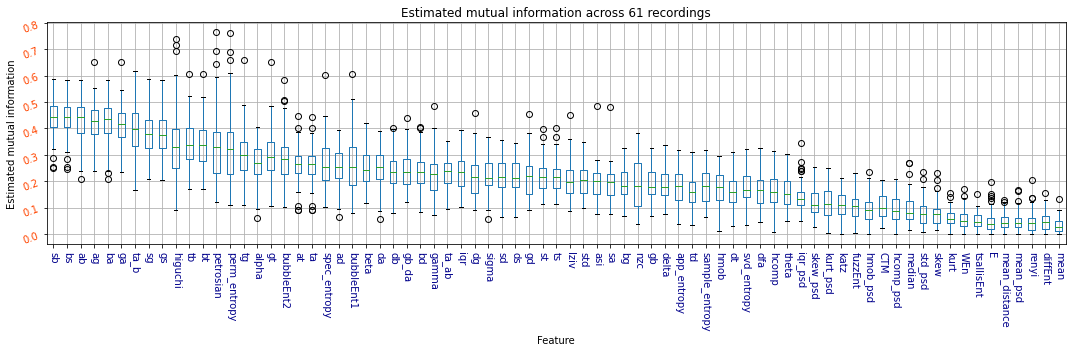

In [12]:
plt.figure(figsize=(15,5))
MI_df = MI_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
MI_rank_df = MI_rank_df.rename(columns={'central_tendency_measure':"CTM"})

MI_df = MI_df.astype(float)
MI_df = MI_df[MI_rank_df.median().sort_values().index]
ax = MI_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("Estimated mutual information")
plt.title(f"Estimated mutual information across {reference_df.shape[0]} recordings")
plt.tight_layout()
# plt.savefig("fs_MI_ranking.png")
# plt.savefig("fs_MI_ranking.svg")
plt.show()

# Chi-sqaured

In [13]:
def minMaxScaler_f(df, feature_range=(0, 1)):
    """
    Example
    -------
    >>> df = pd.DataFrame( {"col1": [1, 3, 5, 7, 9], "col2": [7, 4, 35, 14, 56]} )
    >>> df = minMaxScaler_f(df)
    """
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range)

    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    return df_scaled


def feature_selection_chi_squared(x, y):
    # Chi Squared
    # Feature extraction
    test = SelectKBest(score_func=chi2, k=10)
    fit = test.fit(x, y)
    # Summarize scores
    # np.set_printoptions(precision=3)
    # print(fit.scores_)
    # ranking = fit.get_support()
    # print("Ranking: ", ranking)
    # Summarize selected features
    # features = fit.transform(x)
    fvals = pd.Series(fit.scores_, index=df_feat.columns).sort_values()
    return fvals


chiSqr_df = None

for fname in reference_df.index.to_list():

    # to load hypno:
    hypno_loc = reference_df.loc[fname, "hypno"]
    hypno_30s = np.loadtxt(hypno_loc)[:, 0]

    # to load features:
    df_feat_loc = reference_df.loc[fname, "df_feat"]
    df_feat = pd.read_csv(df_feat_loc, index_col=False)

    df_feat = df_feat.iloc[hypno_30s != -1]  # do not process -1/artifact
    hypno_30s = hypno_30s[hypno_30s != -1]  # do not process -1/artifact

    df_feat = df_feat.replace(
        [np.inf, -np.inf], 0
    )  # Replacing infinite values in features

    # Compute the estimated mutual information between each feature and the target for the provided sample
    chiSqr = feature_selection_chi_squared(minMaxScaler_f(df_feat), hypno_30s)

    # Plot features ranking
    # fig = plt.figure(figsize=(10, 10))
    # plt.suptitle(f"Chi-squared stats of non-negative features {fname}")
    # sns.barplot(y=chiSqr.index, x=chiSqr, palette="RdYlGn")
    # plt.xlabel("Chi sqaured F-values")
    # plt.xticks(rotation=20)
    # plt.yticks(size=8)
    # plt.tight_layout()
    # plt.savefig(f"fs_chiSQR figures/fs_chiSQR {fname}.png", format="png")
    # plt.savefig(f"fs_chiSQR figures/fs_chiSQR {fname}.svg", format="svg")
    # plt.close(fig)

    chiSqr["name"] = fname

    if chiSqr_df is None:  # if not exist, then create it
        chiSqr_df = pd.DataFrame(columns=chiSqr.index)
        chiSqr_df = pd.concat([chiSqr_df, chiSqr.to_frame().T])
    else:  # fill it
        chiSqr_df = pd.concat([chiSqr_df, chiSqr.to_frame().T])

chiSqr_df = chiSqr_df.set_index("name")
chiSqr_rank_df = chiSqr_df.rank(1, ascending=False, method="first")


In [14]:
chiSqr_df.head(3)

,mean,mean_distance,tsallisEnt,skew,ta_ab,WEn,diffEnt,median,skew_psd,hmob_psd,...,petrosian,higuchi,gs,sg,ag,bubbleEnt1,bubbleEnt2,bs,sb,ab
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,0.003892,0.109052,0.238558,1.08214,1.890446,2.456361,3.231831,3.77667,3.831098,3.834351,...,64.18236,74.804517,84.613517,87.525512,97.58009,102.394534,103.224741,103.253779,106.042513,128.016741
P18_N2 R,0.024682,0.143023,0.052576,0.643514,18.616928,1.029289,2.444063,0.616159,0.056103,0.828035,...,48.05587,59.286535,51.186962,40.633803,44.942611,54.814768,58.614046,73.65811,42.169891,72.689763
P17_N2 L,0.000891,0.376701,0.028857,0.554641,4.403943,0.889979,1.739241,6.161013,3.252515,6.01832,...,36.258733,52.068451,42.971433,35.355228,21.18558,32.520032,35.601933,56.439086,63.255756,41.335257


In [15]:
chiSqr_rank_df.head(3)

,mean,mean_distance,tsallisEnt,skew,ta_ab,WEn,diffEnt,median,skew_psd,hmob_psd,...,petrosian,higuchi,gs,sg,ag,bubbleEnt1,bubbleEnt2,bs,sb,ab
name,,,,,,,,,,,,,,,,,,,,,
P18_N3 L,75.0,74.0,73.0,72.0,71.0,70.0,69.0,68.0,67.0,66.0,...,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
P18_N2 R,75.0,72.0,74.0,68.0,44.0,66.0,62.0,69.0,73.0,67.0,...,14.0,8.0,12.0,19.0,17.0,10.0,9.0,5.0,18.0,6.0
P17_N2 L,75.0,73.0,74.0,72.0,57.0,71.0,69.0,49.0,61.0,50.0,...,7.0,3.0,5.0,9.0,24.0,11.0,8.0,2.0,1.0,6.0


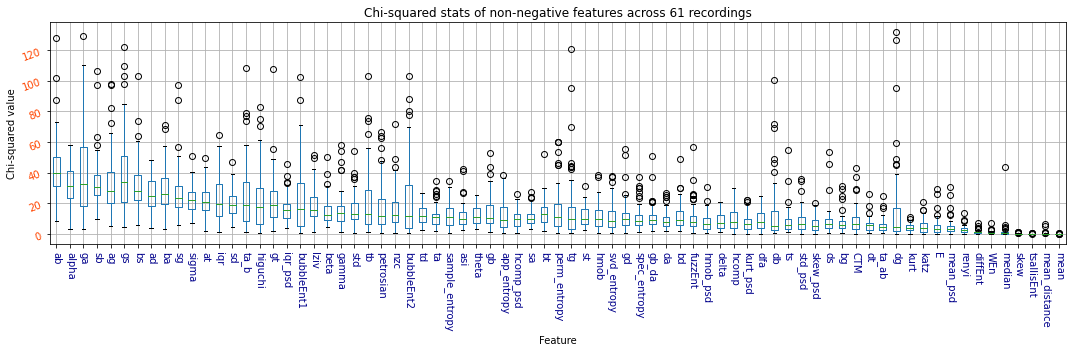

In [16]:
plt.figure(figsize=(15,5))
chiSqr_df = chiSqr_df.rename(columns={'central_tendency_measure':"CTM"}) # first name is too long :) so abbreviate it!
chiSqr_rank_df = chiSqr_rank_df.rename(columns={'central_tendency_measure':"CTM"})

chiSqr_df = chiSqr_df.astype(float)
chiSqr_df = chiSqr_df[chiSqr_rank_df.median().sort_values().index]
ax = chiSqr_df.boxplot()	
ax.tick_params(
    axis="x", labelsize=10,
    labelrotation=-90,
    labelcolor="darkblue")
ax.tick_params(
    axis="y", labelsize=10,
    labelrotation=20,
    labelcolor="orangered")
plt.xlabel("Feature")
plt.ylabel("Chi-squared value")
plt.title(f"Chi-squared stats of non-negative features across {reference_df.shape[0]} recordings")
plt.tight_layout()
# plt.savefig("fs_chiSQR_ranking.png")
# plt.savefig("fs_chiSQR_ranking.svg")
plt.show()



In [17]:
# create a ranking dictionary that contain feature selection algorithm and a list of features with the classification significance order
fvals_df = fvals_df[fvals_rank_df.mean().sort_values().index]
f1 = dict(zip(fvals_df.columns.values.tolist(), range(1,75+1)))
f1 = pd.Series(f1, index=f1.keys())
f1["method_name"] = "f_classif"
f1 = f1.sort_index(ascending=True)
f1 = f1.to_frame()
f1 = f1.T

MI_df = MI_df[MI_rank_df.mean().sort_values().index]
f2 = dict(zip(MI_df.columns.values.tolist(), range(1,75+1)))
f2 = pd.Series(f2, index=f2.keys())
f2["method_name"] = "MI"
f2 = f2.sort_index(ascending=True)
f2 = f2.to_frame()
f2 = f2.T

chiSqr_df = chiSqr_df[chiSqr_rank_df.mean().sort_values().index]
f3 = dict(zip(chiSqr_df.columns.values.tolist(), range(1,75+1)))
f3 = pd.Series(f3, index=f3.keys())
f3["method_name"] = "chiSqr"
f3 = f3.sort_index(ascending=True)
f3 = f3.to_frame()
f3 = f3.T

rankings_df = pd.concat([f1, f2, f3])
rankings_df = rankings_df.set_index("method_name")

In [18]:
rankings_df

,CTM,E,WEn,ab,ad,ag,alpha,app_entropy,asi,at,...,svd_entropy,ta,ta_ab,ta_b,tb,td,tg,theta,ts,tsallisEnt
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,62,67,69,2,16,4,7,41,23,8,...,39,19,31,6,15,35,28,33,44,74
MI,62,73,68,2,22,4,17,48,43,20,...,50,21,30,7,10,51,15,55,38,69
chiSqr,59,67,71,1,10,6,5,41,36,13,...,46,32,63,16,21,27,38,31,58,74


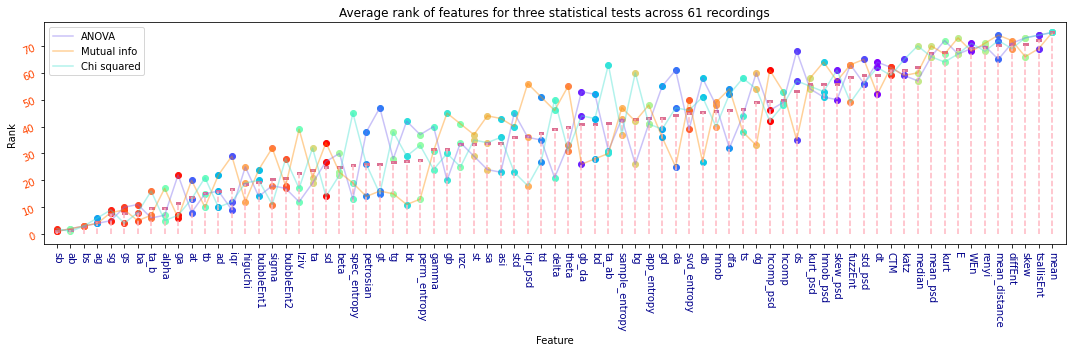

In [19]:
rankings_df = rankings_df.astype(float)
rankings_df = rankings_df[rankings_df.mean().sort_values().index] # ***** columns sorted here based on mean over three tests

fig, ax = plt.subplots(figsize=(15, 5))

from matplotlib.pyplot import cm, xticks

color = cm.rainbow(np.linspace(0, 1, 75))
np.random.shuffle(color)
color = iter(color)

for i in range(75):
    c = next(color)
    ax.scatter(i, rankings_df.to_numpy()[0, i], color=c)
    ax.scatter(i, rankings_df.to_numpy()[1, i], color=c)
    ax.scatter(i, rankings_df.to_numpy()[2, i], color=c)
    pnts = np.array(
        [
            rankings_df.to_numpy()[0, i],
            rankings_df.to_numpy()[1, i],
            rankings_df.to_numpy()[2, i],
        ]
    )
    ax.plot(
        [i - 0.1, i + 0.1],
        [np.mean(pnts), np.mean(pnts)],
        "-",
        color="palevioletred",
        linewidth=3,
    )
    ax.plot([i, i], [0, np.mean(pnts)], "--", color="lightpink")

ax.plot(
    range(75),
    rankings_df.to_numpy()[0, :],
    linewidth=1.5,
    alpha=0.4,
    color="mediumslateblue",
    label="ANOVA",
)
ax.plot(
    range(75),
    rankings_df.to_numpy()[1, :],
    linewidth=1.5,
    alpha=0.4,
    color="darkorange",
    label="Mutual info",
)
ax.plot(
    range(75),
    rankings_df.to_numpy()[2, :],
    linewidth=1.5,
    alpha=0.4,
    color="turquoise",
    label="Chi squared",
)

ax.set(xlabel="Feature", ylabel="Rank", xlim=[-1, 75])
plt.title(
    f"Average rank of features for three statistical tests across {reference_df.shape[0]} recordings"
)
ax.set(xticks=range(75), xticklabels=rankings_df.columns.values.tolist())
ax.tick_params(axis="x", labelsize=10, labelrotation=-90, labelcolor="darkblue")
ax.tick_params(axis="y", labelsize=10, labelrotation=20, labelcolor="orangered")
plt.legend()
plt.tight_layout()
# plt.savefig("fs_overall_ranking.png")
# plt.savefig("fs_overall_ranking.svg")
plt.show()


In [20]:
rankings_df.head()

,sb,ab,bs,ag,sg,gs,ba,ta_b,alpha,ga,...,mean_psd,kurt,E,WEn,renyi,mean_distance,diffEnt,skew,tsallisEnt,mean
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,1.0,2.0,3.0,4.0,5.0,10.0,11.0,6.0,7.0,22.0,...,66.0,72.0,67.0,69.0,70.0,65.0,71.0,73.0,74.0,75.0
MI,1.0,2.0,3.0,4.0,8.0,9.0,5.0,7.0,17.0,6.0,...,70.0,67.0,73.0,68.0,71.0,74.0,72.0,66.0,69.0,75.0
chiSqr,2.0,1.0,3.0,6.0,9.0,4.0,8.0,16.0,5.0,7.0,...,66.0,64.0,67.0,71.0,68.0,72.0,69.0,73.0,74.0,75.0


# Correlation Analysis of Top features

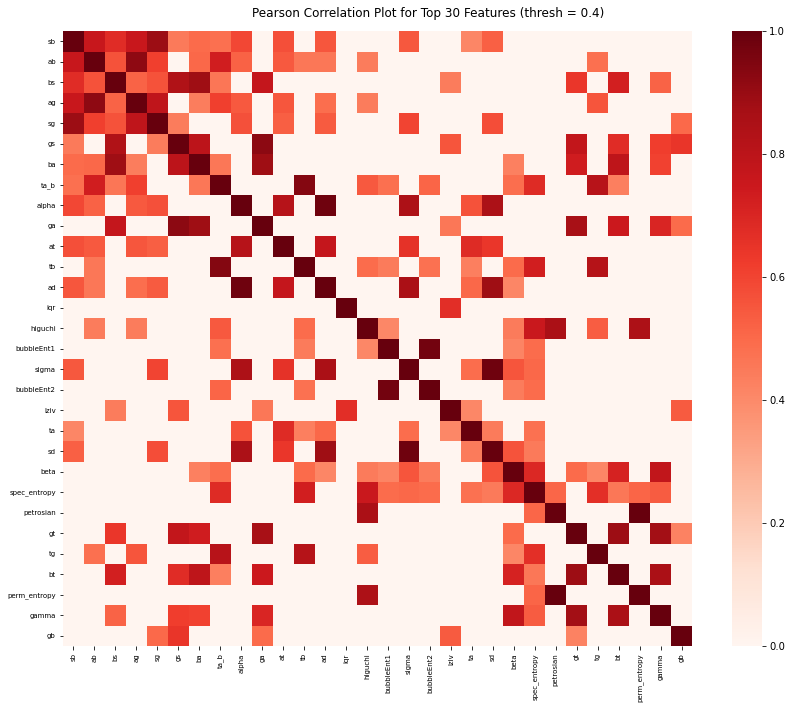

In [21]:
def pearson_correlation_print(df):
    # Using Pearson Correlation

    # plt.figure(figsize=(12, 10))
    corr_matrix = df.corr()
    # sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
    # plt.show()

    outputVariables = ["hmob"]
    for outputVariable in outputVariables:
        # Correlation with output variable
        cor_target = abs(corr_matrix[outputVariable])
        # Selecting highly correlated features
        relevant_features = cor_target[cor_target >= 0.8]
        print(f"RELEVANT ONES to {outputVariable}:")
        print(relevant_features)
        print()


def pearson_correlation_plot(df, thresh=0.95):
    plt.figure(figsize=(12, 10))
    plt.suptitle(f"Pearson Correlation Plot for Top 30 Features (thresh = {thresh})")
    corr_matrix = df.corr()
    corr_matrix[abs(corr_matrix) >= thresh] = abs(corr_matrix)
    corr_matrix[abs(corr_matrix) < thresh] = 0
    # print(corr_matrix.shape)
    g = sns.heatmap(
        abs(corr_matrix), cmap=plt.cm.Reds, xticklabels=True, yticklabels=True
    )
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize=7)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize=7)
    plt.tight_layout()
    # plt.savefig(f"fs_pearson_correlation_top_30_thresh_{thresh}.png", format="png")
    # plt.savefig(f"fs_pearson_correlation_top_30_thresh_{thresh}.svg", format="svg")
    plt.show()


top_30_features = rankings_df.columns.values.tolist()[0:30]
pearson_correlation_plot(df_feat.loc[:, top_30_features], thresh=0.4)


# 

In [22]:
rankings_df.head()

,sb,ab,bs,ag,sg,gs,ba,ta_b,alpha,ga,...,mean_psd,kurt,E,WEn,renyi,mean_distance,diffEnt,skew,tsallisEnt,mean
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,1.0,2.0,3.0,4.0,5.0,10.0,11.0,6.0,7.0,22.0,...,66.0,72.0,67.0,69.0,70.0,65.0,71.0,73.0,74.0,75.0
MI,1.0,2.0,3.0,4.0,8.0,9.0,5.0,7.0,17.0,6.0,...,70.0,67.0,73.0,68.0,71.0,74.0,72.0,66.0,69.0,75.0
chiSqr,2.0,1.0,3.0,6.0,9.0,4.0,8.0,16.0,5.0,7.0,...,66.0,64.0,67.0,71.0,68.0,72.0,69.0,73.0,74.0,75.0


In [23]:
# write to csv    
rankings_df = rankings_df.rename(columns={'CTM':"central_tendency_measure"}) # return back to standard
rankings_df.to_csv("rankings_df.csv")

In [24]:
# load csv    
rankings_df = pd.read_csv("rankings_df.csv", index_col="method_name")

In [25]:
rankings_df.head()

,sb,ab,bs,ag,sg,gs,ba,ta_b,alpha,ga,...,mean_psd,kurt,E,WEn,renyi,mean_distance,diffEnt,skew,tsallisEnt,mean
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,1.0,2.0,3.0,4.0,5.0,10.0,11.0,6.0,7.0,22.0,...,66.0,72.0,67.0,69.0,70.0,65.0,71.0,73.0,74.0,75.0
MI,1.0,2.0,3.0,4.0,8.0,9.0,5.0,7.0,17.0,6.0,...,70.0,67.0,73.0,68.0,71.0,74.0,72.0,66.0,69.0,75.0
chiSqr,2.0,1.0,3.0,6.0,9.0,4.0,8.0,16.0,5.0,7.0,...,66.0,64.0,67.0,71.0,68.0,72.0,69.0,73.0,74.0,75.0
